In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py


In [2]:
#Inflate pos predictions

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1], fold_suffixes=['', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []
    
    sed_scores = None

    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        sed = h5py.File('models/f' + str(fold_ix) + 'c0' + fold_suffix + '/gtexg/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat = sed['logSED'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        if fold_i == 0 :
            sed_scores = np.abs(score_mat.copy())
        else :
            sed_scores += np.abs(score_mat.copy())
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        preds = []
        ref_alleles = []
        alt_alleles = []

        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            preds.append(np.mean(np.abs(score_mat[i, :])))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'delta_score' : preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    sed_scores /= float(len(df_folds))
    
    df['row_index'] = np.arange(len(df), dtype=np.int32)
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat_2/eqtl3_pip70ea/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=6)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split(";PD=")[1].split(";PI=")[0]).astype(int)
    vcf_df['finemap_gene_id'] = vcf_df['INFO'].apply(lambda x: x.split("MT=")[1].split(";")[0])
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("PI=")[1].split(";")[0])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'finemap_gene_id', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df, sed_scores

df_snp_pos, scores_pos = inflate_snp_predictions('pos', [0, 1], ['', ''])
df_snp_neg, scores_neg = inflate_snp_predictions('neg', [0, 1], ['', ''])

#Rename borzoi VEP score
df_snp_pos = df_snp_pos.rename(columns={'delta_score' : 'delta_score_borzoi'})
df_snp_neg = df_snp_neg.rename(columns={'delta_score' : 'delta_score_borzoi'})


Inflating predictions for 'pos'.
len(df) = 5972
len(df) = 5972
Inflating predictions for 'neg'.
len(df) = 9534
len(df) = 9534


In [3]:

target_ids = h5py.File('models/f0c0/gtexg/merge_pos/sed.h5', 'r')['target_ids'][()]
target_ids = [tid.decode() for tid in target_ids.tolist()]

target_name_dict = pd.read_csv('targets_human_rna.txt', sep='\t')[['identifier', 'description']].set_index('identifier').to_dict(orient='index')

target_names = []
for tid in target_ids :
    target_names.append(target_name_dict[tid]['description'])


In [4]:
#Filter on matched gene

df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg['gene_id_base'] = df_snp_neg['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)

scores_pos = scores_pos[df_snp_pos['row_index'].values.tolist(), :]
scores_neg = scores_neg[df_snp_neg['row_index'].values.tolist(), :]


In [5]:
#Append saluki ensemble predictions

df_saluki_pos = None
df_saluki_neg = None
for fold_ix in range(10) :
    for cross_ix in range(5) :
        df_saluki_pos_curr = pd.read_csv('/home/jlinder/analysis/saluki/gtex/f' + str(fold_ix) + 'c' + str(cross_ix) + '/pos_merge/ssd.tsv', sep='\t')
        df_saluki_neg_curr = pd.read_csv('/home/jlinder/analysis/saluki/gtex/f' + str(fold_ix) + 'c' + str(cross_ix) + '/neg_merge/ssd.tsv', sep='\t')
        
        df_saluki_pos_curr['SSD0'] = np.abs(df_saluki_pos_curr['SSD0'])
        df_saluki_neg_curr['SSD0'] = np.abs(df_saluki_neg_curr['SSD0'])
        
        if df_saluki_pos is None :
            df_saluki_pos = df_saluki_pos_curr.copy()
            df_saluki_neg = df_saluki_neg_curr.copy()
        else :
            df_saluki_pos['SSD0'] += df_saluki_pos_curr['SSD0'] / 50.
            df_saluki_neg['SSD0'] += df_saluki_neg_curr['SSD0'] / 50.

#df_saluki_pos['SSD0'] = np.abs(df_saluki_pos['SSD0'])
#df_saluki_neg['SSD0'] = np.abs(df_saluki_neg['SSD0'])

#Drop duplicate variants
df_saluki_pos = df_saluki_pos.groupby('variant').agg({'SSD0' : 'max'}).copy().reset_index()
df_saluki_neg = df_saluki_neg.groupby('variant').agg({'SSD0' : 'max'}).copy().reset_index()

print("len(len(df_saluki_pos)) = " + str(len(df_saluki_pos)))
print("len(len(df_saluki_neg)) = " + str(len(df_saluki_neg)))

df_snp_pos = df_snp_pos.join(df_saluki_pos.set_index('variant'), on='snp', how='inner').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(df_saluki_neg.set_index('variant'), on='snp', how='inner').copy().reset_index(drop=True)


len(len(df_saluki_pos)) = 313
len(len(df_saluki_neg)) = 652


In [6]:
#Sort by SNP

df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)


n pos = 299
n neg = 635


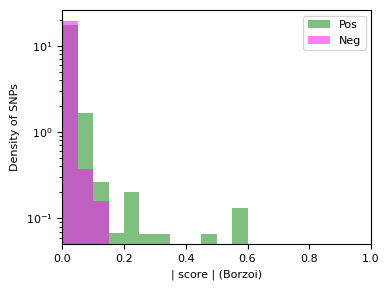

In [8]:
#Plot distribution of SNP effect sizes

import matplotlib.pyplot as plt

filter_query = "min_dist <= 2000"

pos_score = np.clip(np.abs(df_snp_pos.query(filter_query)['delta_score_borzoi'].values), 0.0, 1.0)
neg_score = np.clip(np.abs(df_snp_neg.query(filter_query)['delta_score_borzoi'].values), 0.0, 1.0)

print("n pos = " + str(pos_score.shape[0]))
print("n neg = " + str(neg_score.shape[0]))

f = plt.figure(figsize=(4, 3))

plt.hist(pos_score, bins=20, color='green', range=(0.0, 1.0), density=True, log=True, alpha=0.5, label='Pos')
plt.hist(neg_score, bins=20, color='magenta', range=(0.0, 1.0), density=True, log=True, alpha=0.5, label='Neg')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("| score | (Borzoi)", fontsize=8)
plt.ylabel("Density of SNPs", fontsize=8)

plt.xlim(0.0, 1.0)

plt.legend(fontsize=8)

plt.tight_layout()

plt.show()


- n pos = 299
- n neg = 299
- n sample = 239
- n pos = 285
- n neg = 285
- n sample = 228
- n pos = 209
- n neg = 209
- n sample = 167
- n pos = 175
- n neg = 175
- n sample = 140
- n pos = 135
- n neg = 135
- n sample = 108
- n pos = 87
- n neg = 87
- n sample = 69
- n pos = 53
- n neg = 53
- n sample = 42


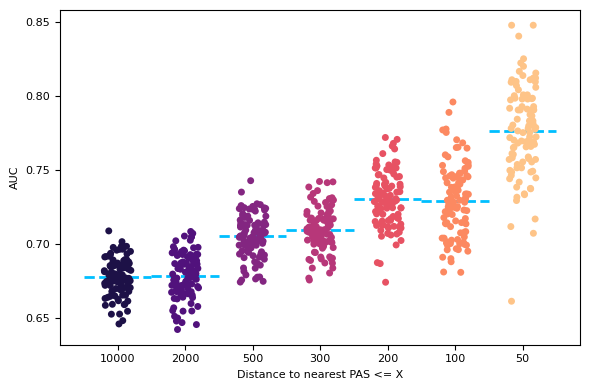

In [9]:
#Evaluate SNP classification performance based on scalar effect size predictions, as a function of SNP-PAS distance

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

frac_sample = 0.8
n_shuffles = 100
min_distances = [10000, 2000, 500, 300, 200, 100, 50]

auc_mat = np.zeros((len(min_distances), n_shuffles))

for min_dist_ix, min_dist in enumerate(min_distances) :
    
    filter_query = "min_dist <= " + str(min_dist)

    df_snp_pos['is_causal'] = 1
    df_snp_neg['is_causal'] = 0

    df_snp_pos_filtered = df_snp_pos.query(filter_query)
    df_snp_neg_filtered = df_snp_neg.query(filter_query)

    shuffle_index_pos = np.arange(len(df_snp_pos_filtered))
    shuffle_index_neg = np.arange(len(df_snp_neg_filtered))

    aucs = []

    for shuffle_ix in range(n_shuffles) :

        np.random.shuffle(shuffle_index_pos)
        np.random.shuffle(shuffle_index_neg)
        
        df_snp_pos_shuffled = df_snp_pos_filtered.iloc[shuffle_index_pos].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_filtered.iloc[shuffle_index_neg].copy().reset_index(drop=True)
        
        #Select unique matched IDs
        df_snp_pos_shuffled = df_snp_pos_shuffled.drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.drop_duplicates(subset=['matched_snp'], keep='first').copy().reset_index(drop=True)

        df_snp_pos_shuffled = df_snp_pos_shuffled.loc[df_snp_pos_shuffled['snp'].isin(df_snp_neg_shuffled['matched_snp'])].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.loc[df_snp_neg_shuffled['matched_snp'].isin(df_snp_pos_shuffled['snp'])].copy().reset_index(drop=True)

        if shuffle_ix == 0 :
            print("- n pos = " + str(len(df_snp_pos_shuffled)))
            print("- n neg = " + str(len(df_snp_neg_shuffled)))

        n_min = min(len(df_snp_pos_shuffled), len(df_snp_neg_shuffled))
        n_sample = int(frac_sample * n_min)

        if shuffle_ix == 0 :
            print("- n sample = " + str(n_sample))

        df_snp = pd.concat([df_snp_pos_shuffled.iloc[:n_sample], df_snp_neg_shuffled.iloc[:n_sample]])

        score = np.abs(np.array(df_snp['delta_score_borzoi'].values))
        label = np.array(df_snp['is_causal'].values)

        #AUC score
        fpr, tpr, _ = roc_curve(label, score)

        auc = roc_auc_score(label, score)
        aucs.append(auc)
    
    auc_mat[min_dist_ix, :] = np.array(aucs)

import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[auc_mat[i, :] for i in range(auc_mat.shape[0])], jitter=0.2, palette='magma')

for i in range(auc_mat.shape[0]) :
    plt.plot([i-0.5, i+0.5], [np.mean(auc_mat[i, :]), np.mean(auc_mat[i, :])], color='deepskyblue', linewidth=2, linestyle='--')

plt.xticks(np.arange(len(min_distances)), min_distances, fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUC", fontsize=8)

plt.tight_layout()

plt.show()


- n pos = 299
- n neg = 299
- n sample = 239
- n pos = 285
- n neg = 285
- n sample = 228
- n pos = 209
- n neg = 209
- n sample = 167
- n pos = 175
- n neg = 175
- n sample = 140
- n pos = 135
- n neg = 135
- n sample = 108
- n pos = 87
- n neg = 87
- n sample = 69
- n pos = 53
- n neg = 53
- n sample = 42


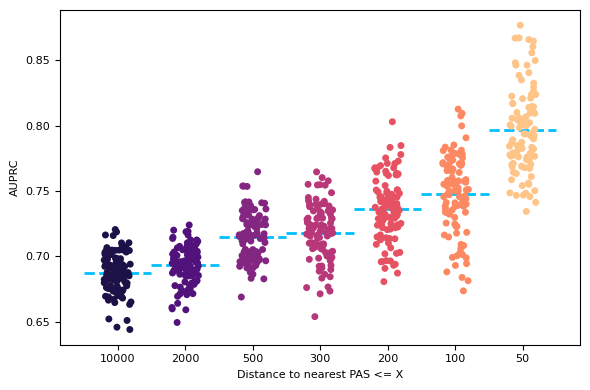

In [10]:
#Evaluate SNP classification performance based on scalar effect size predictions, controlling for SNP-PAS distance (APRs)

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

frac_sample = 0.8
n_shuffles = 100
min_distances = [10000, 2000, 500, 300, 200, 100, 50]

ap_mat = np.zeros((len(min_distances), n_shuffles))

for min_dist_ix, min_dist in enumerate(min_distances) :
    
    filter_query = "min_dist <= " + str(min_dist)

    df_snp_pos['is_causal'] = 1
    df_snp_neg['is_causal'] = 0

    df_snp_pos_filtered = df_snp_pos.query(filter_query)
    df_snp_neg_filtered = df_snp_neg.query(filter_query)

    shuffle_index_pos = np.arange(len(df_snp_pos_filtered))
    shuffle_index_neg = np.arange(len(df_snp_neg_filtered))

    aps = []

    for shuffle_ix in range(n_shuffles) :

        np.random.shuffle(shuffle_index_pos)
        np.random.shuffle(shuffle_index_neg)
        
        df_snp_pos_shuffled = df_snp_pos_filtered.iloc[shuffle_index_pos].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_filtered.iloc[shuffle_index_neg].copy().reset_index(drop=True)
        
        #Select unique matched IDs
        df_snp_pos_shuffled = df_snp_pos_shuffled.drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.drop_duplicates(subset=['matched_snp'], keep='first').copy().reset_index(drop=True)

        df_snp_pos_shuffled = df_snp_pos_shuffled.loc[df_snp_pos_shuffled['snp'].isin(df_snp_neg_shuffled['matched_snp'])].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.loc[df_snp_neg_shuffled['matched_snp'].isin(df_snp_pos_shuffled['snp'])].copy().reset_index(drop=True)

        if shuffle_ix == 0 :
            print("- n pos = " + str(len(df_snp_pos_shuffled)))
            print("- n neg = " + str(len(df_snp_neg_shuffled)))

        n_min = min(len(df_snp_pos_shuffled), len(df_snp_neg_shuffled))
        n_sample = int(frac_sample * n_min)

        if shuffle_ix == 0 :
            print("- n sample = " + str(n_sample))

        df_snp = pd.concat([df_snp_pos_shuffled.iloc[:n_sample], df_snp_neg_shuffled.iloc[:n_sample]])

        score = np.abs(np.array(df_snp['delta_score_borzoi'].values))
        distance = -np.abs(np.array(df_snp['min_dist'].values))
        label = np.array(df_snp['is_causal'].values)

        #Precision-recall scores
        ap = average_precision_score(label, score)

        aps.append(ap)
    
    ap_mat[min_dist_ix, :] = np.array(aps)

import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[ap_mat[i, :] for i in range(ap_mat.shape[0])], jitter=0.2, palette='magma')

for i in range(ap_mat.shape[0]) :
    plt.plot([i-0.5, i+0.5], [np.mean(ap_mat[i, :]), np.mean(ap_mat[i, :])], color='deepskyblue', linewidth=2, linestyle='--')

plt.xticks(np.arange(len(min_distances)), min_distances, fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUPRC", fontsize=8)

plt.tight_layout()

plt.show()


In [10]:
np.save('gtex_mean_ap', ap_mat)

In [11]:

ap_mat_s = np.load('../hl_clip/gtex_mean_ap_s.npy')
ap_mat_bl = np.load('../baseline_micro/gtex_mean_ap_bl.npy')
ap_mat_bl_mini = np.load('../baseline/gtex_mean_ap_bl.npy')
ap_mat_hl2 = np.load('../hl_micro/gtex_mean_ap.npy')
ap_mat_hl_clip2 = np.load('../hl_clip_micro/gtex_mean_ap.npy')
ap_mat_hl_clip2_mini = np.load('../hl_clip/gtex_mean_ap.npy')

ap_mat_r = np.concatenate([
    ap_mat_s[:, None, :],
    ap_mat_bl[:, None, :],
    ap_mat_bl_mini[:, None, :],
    ap_mat_hl2[:, None, :],
    ap_mat_hl_clip2[:, None, :],
    ap_mat_hl_clip2_mini[:, None, :],
], axis=1)


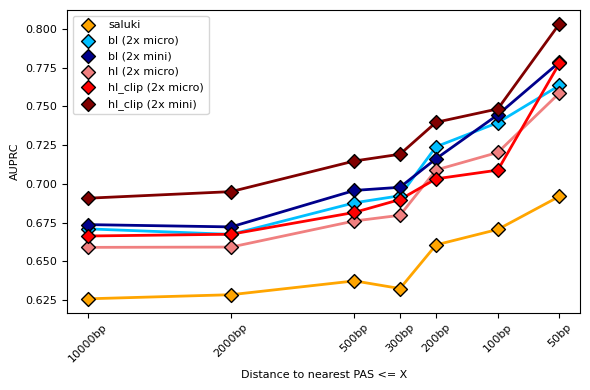

In [12]:
#Plot AP trajectories

model_colors = ['orange', 'deepskyblue', 'darkblue', 'lightcoral', 'red', 'maroon']
model_names = ['saluki', 'bl (2x micro)', 'bl (2x mini)', 'hl (2x micro)', 'hl_clip (2x micro)', 'hl_clip (2x mini)']

f = plt.figure(figsize=(6, 4))

for j in range(ap_mat_r.shape[1]) :
    plt.scatter(np.log10(np.array(min_distances)), np.mean(ap_mat_r[:, j, :], axis=-1), s=50, marker='D', color=model_colors[j], edgecolor='black', linewidth=1, label=model_names[j], zorder=1)
    plt.plot(np.log10(np.array(min_distances)), np.mean(ap_mat_r[:, j, :], axis=-1), color=model_colors[j], linewidth=2, zorder=-1)

plt.legend(fontsize=8)

plt.xticks(np.log10(min_distances), [str(min_distances[k]) + "bp" for k in range(len(min_distances))], fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUPRC", fontsize=8)

#plt.ylim(1.1, 1.55)

plt.xlim(np.max(np.log10(min_distances))+0.025*np.max(np.log10(min_distances)), np.min(np.log10(min_distances))-0.025*np.max(np.log10(min_distances)))

plt.tight_layout()

plt.show()
